In [18]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Define a preprocessing transformation to convert MNIST to RGB
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.Resize(224),  # Resize to match MobileNetV2 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Load and preprocess the Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 26421880/26421880 [00:02<00:00, 12389977.39it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211169.02it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3902580.07it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7552387.90it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:

# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 76.7MB/s]


In [6]:

# Modify the model's classifier for MNIST (since MNIST has 10 classes)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 10)

In [7]:

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [9]:
import matplotlib.pyplot as plt
import numpy as np# Define a function to plot images with their ground truth and predicted labels

# Define a function to plot ground truth labels
def plot_ground_truth(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax = axes[i]
        image = images[i].squeeze().numpy()  # Squeeze to remove the extra dimension
        ax.imshow(image, cmap='gray')  # Convert and plot as grayscale
        ax.set_title(f'Ground Truth: {labels[i]}')
        ax.axis('off')


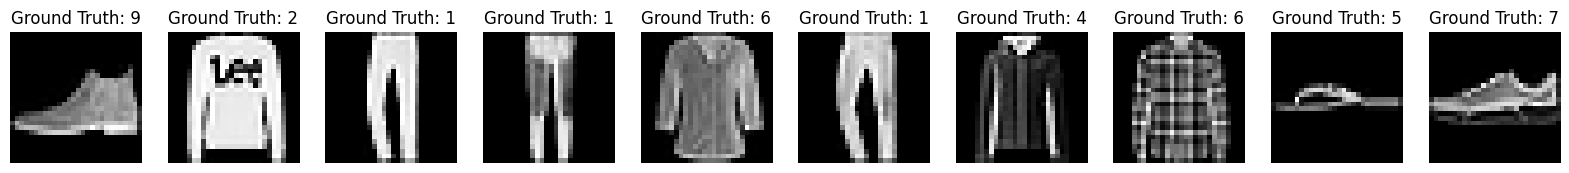

In [10]:
# Plot a subset of ground truth images
num_images_to_plot = 10
plot_ground_truth(test_dataset.data, test_dataset.targets, num_images=num_images_to_plot)

plt.show()

# Evaluating Training dataset Accuracy:
- Here i have used 10 epochs which means i will give whole dataset of Mnist 10 times to the model to do training.
- It will calculate training accuracy and training loss of the model by using this training function.
- This will help us to evaluate that how well our model is performing after using MobileNet model.

In [11]:
# Training loop
num_epochs = 10
training_losses = []
training_accuracy = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    training_losses.append(running_loss / len(train_loader))
    training_accuracy.append(train_accuracy)

    # Print training loss and accuracy
    print(f"[Epoch {epoch + 1}] Training Loss: {running_loss / len(train_loader):.3f}, Training Accuracy: {train_accuracy:.2f}%")


[Epoch 1] Training Loss: 0.302, Training Accuracy: 89.18%
[Epoch 2] Training Loss: 0.224, Training Accuracy: 92.02%
[Epoch 3] Training Loss: 0.194, Training Accuracy: 93.15%
[Epoch 4] Training Loss: 0.175, Training Accuracy: 93.74%
[Epoch 5] Training Loss: 0.162, Training Accuracy: 94.25%
[Epoch 6] Training Loss: 0.149, Training Accuracy: 94.63%
[Epoch 7] Training Loss: 0.138, Training Accuracy: 95.03%
[Epoch 8] Training Loss: 0.130, Training Accuracy: 95.31%
[Epoch 9] Training Loss: 0.116, Training Accuracy: 95.81%
[Epoch 10] Training Loss: 0.109, Training Accuracy: 96.09%


In [27]:
# Create lists to store ground truth labels and predicted labels
all_labels = []
all_predictions = []

# Evaluate the model on the test set
model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        test_outputs = model(test_images)
        _, test_predicted = torch.max(test_outputs.data, 1)

        all_labels.extend(test_labels.cpu().numpy())
        all_predictions.extend(test_predicted.cpu().numpy())

        total_test += test_labels.size(0)
        correct_test += (test_predicted == test_labels).sum().item()

test_accuracy = 100 * correct_test / total_test

print(f"Test Accuracy: {test_accuracy:.2f}%")



Test Accuracy: 93.56%


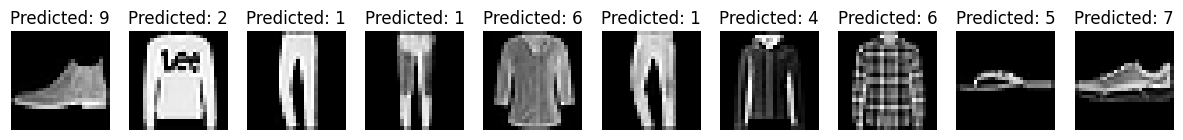

In [28]:
# Assuming you have already trained your model and have a trained_model

# Evaluate the model on the test data and get predictions
model.eval()
predicted_labels = []

with torch.no_grad():
    for data in test_loader:
        images, _ = data
        images = images.to(device)  # Move images to the GPU if available
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

# Now that you have predicted_labels, you can use your plot_predicted function
num_images_to_plot = 10
plot_predicted(test_dataset.data, predicted_labels, num_images=num_images_to_plot)
plt.show()



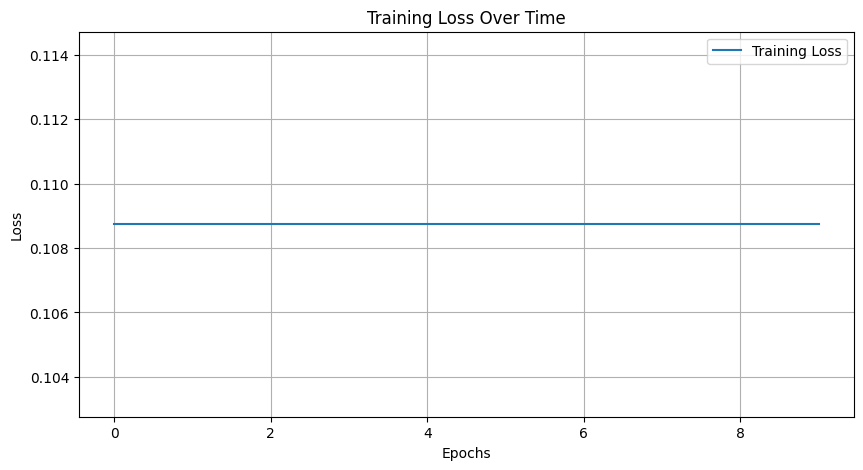

In [29]:
# Plot the training loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), training_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# Create a confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
print("Test Confusion Matrix:")
print(cm)

Test Confusion Matrix:
[[879   1  24   9   1   0  84   0   2   0]
 [  2 986   0   8   1   0   1   0   2   0]
 [ 12   1 926   8  15   0  38   0   0   0]
 [ 10   0   9 948   8   0  25   0   0   0]
 [  0   1  39  27 894   0  39   0   0   0]
 [  0   0   0   1   0 977   0  18   0   4]
 [ 89   0  34  17  30   0 826   0   4   0]
 [  0   0   0   0   0   1   0 981   0  18]
 [  1   1   4   9   1   2   0   2 980   0]
 [  0   0   0   1   0   4   1  35   0 959]]


In [31]:
# Generate a classification report
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # Fashion MNIST class names
target_names = [f'Class {i}: {class_names[i]}' for i in range(10)]
report = classification_report(all_labels, all_predictions, target_names=target_names)
print("Classification Report:")
print(report)

Classification Report:
                      precision    recall  f1-score   support

Class 0: T-shirt/top       0.89      0.88      0.88      1000
    Class 1: Trouser       1.00      0.99      0.99      1000
   Class 2: Pullover       0.89      0.93      0.91      1000
      Class 3: Dress       0.92      0.95      0.93      1000
       Class 4: Coat       0.94      0.89      0.92      1000
     Class 5: Sandal       0.99      0.98      0.98      1000
      Class 6: Shirt       0.81      0.83      0.82      1000
    Class 7: Sneaker       0.95      0.98      0.96      1000
        Class 8: Bag       0.99      0.98      0.99      1000
 Class 9: Ankle boot       0.98      0.96      0.97      1000

            accuracy                           0.94     10000
           macro avg       0.94      0.94      0.94     10000
        weighted avg       0.94      0.94      0.94     10000



<Axes: >

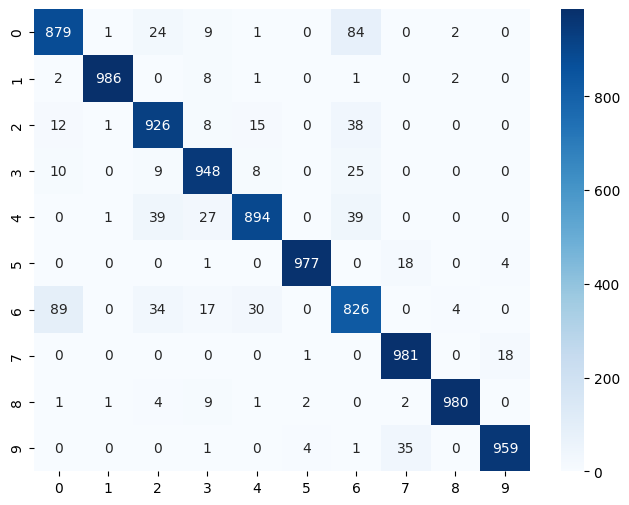

In [33]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")